Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# 3 Major enablers for AI from CLOUD to EDGE -->

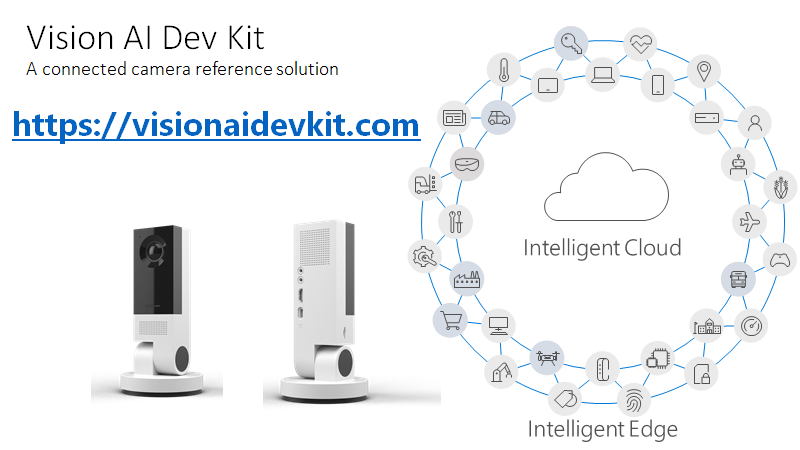

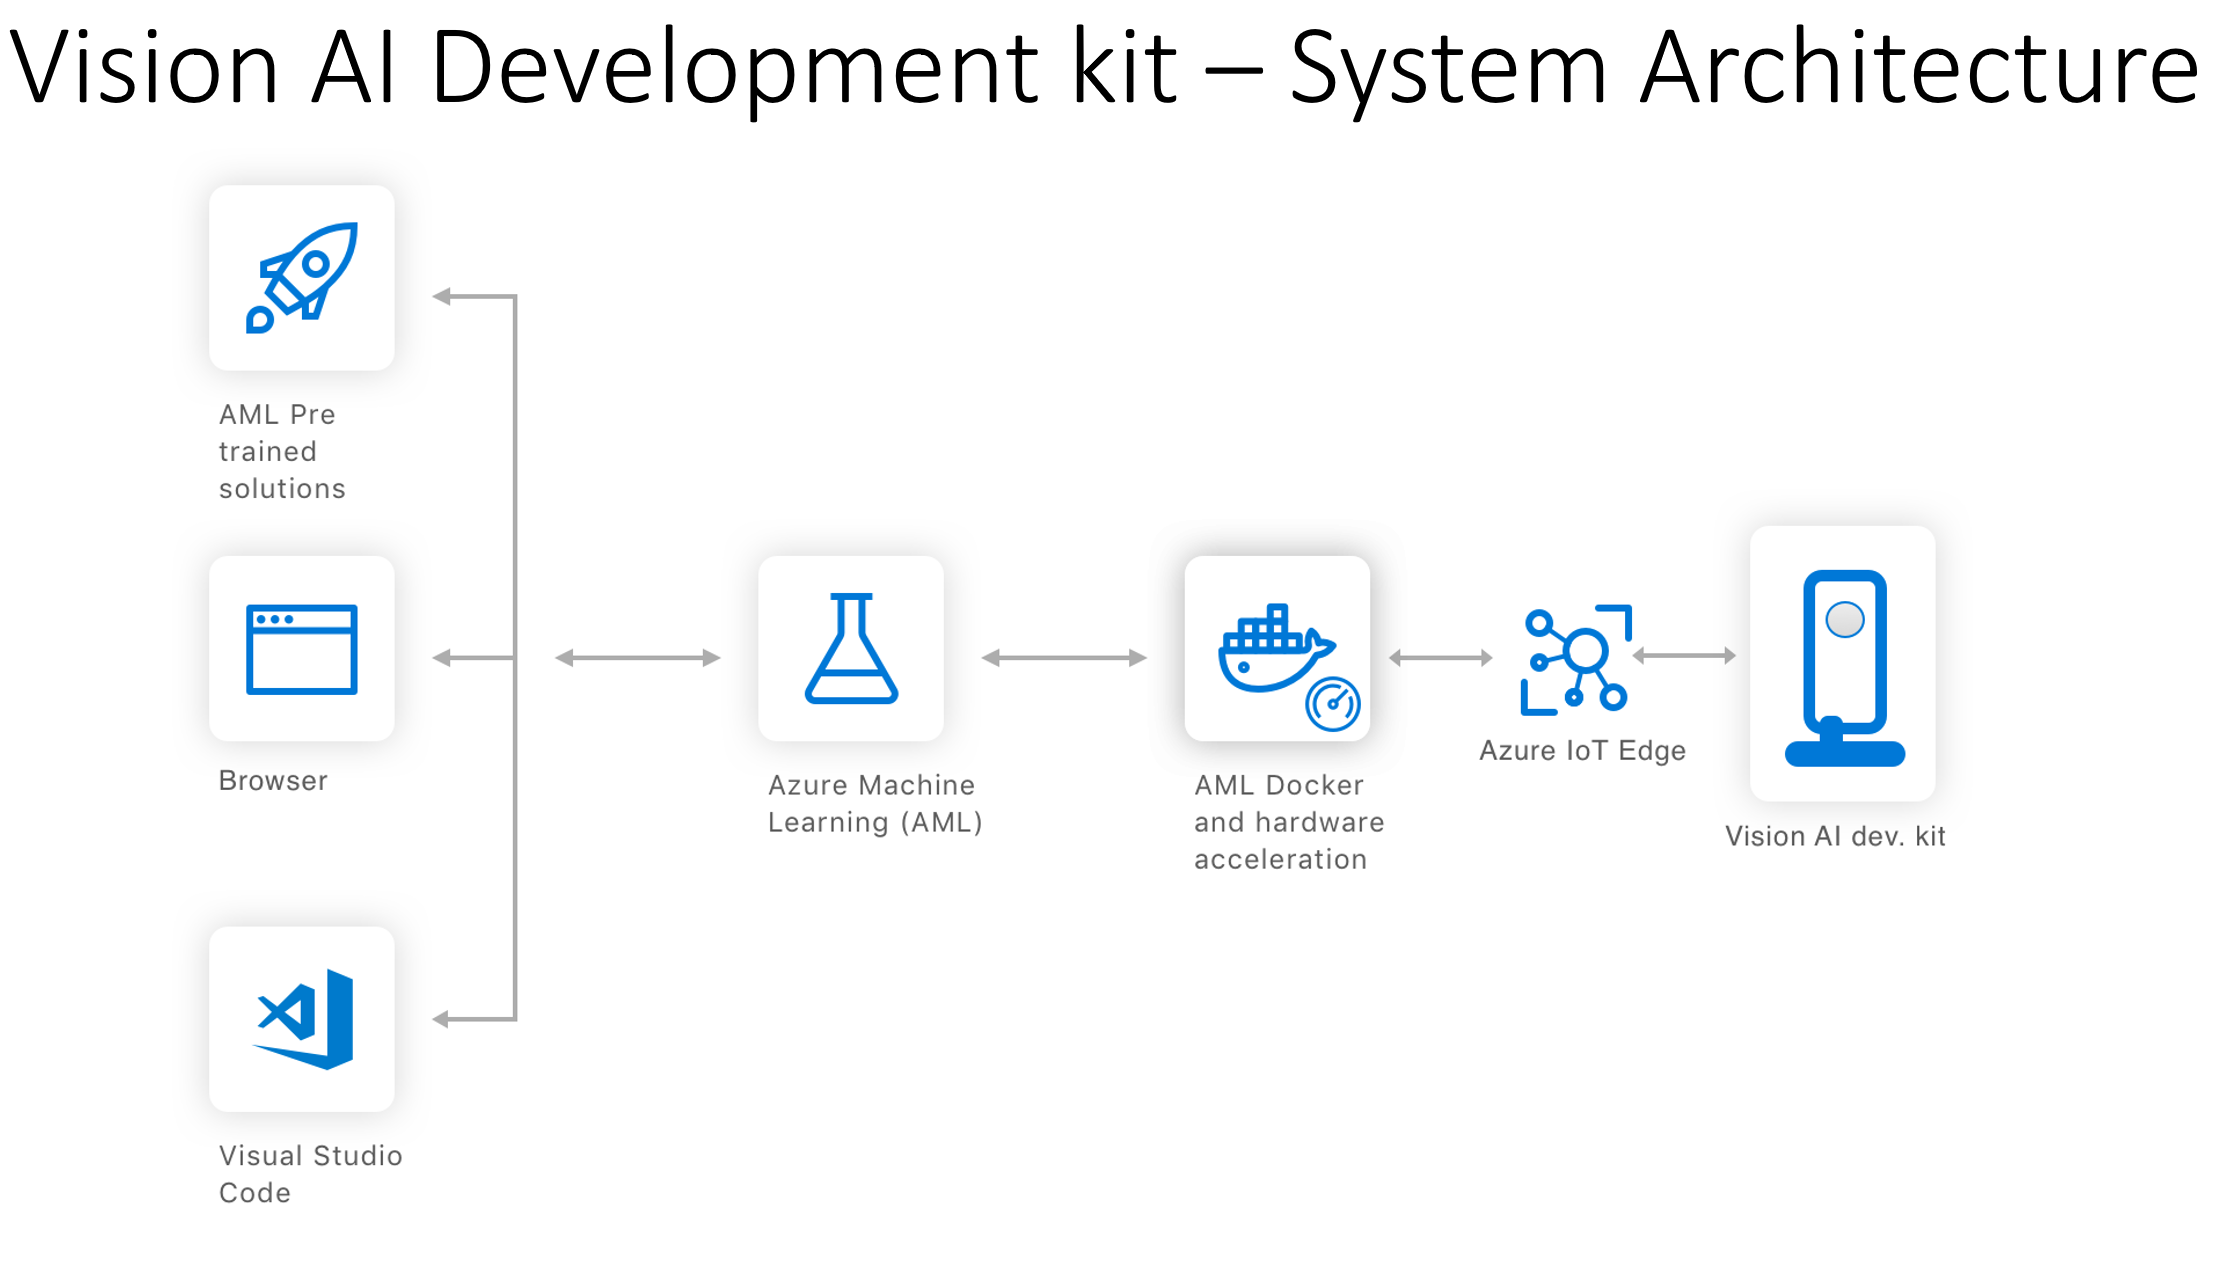

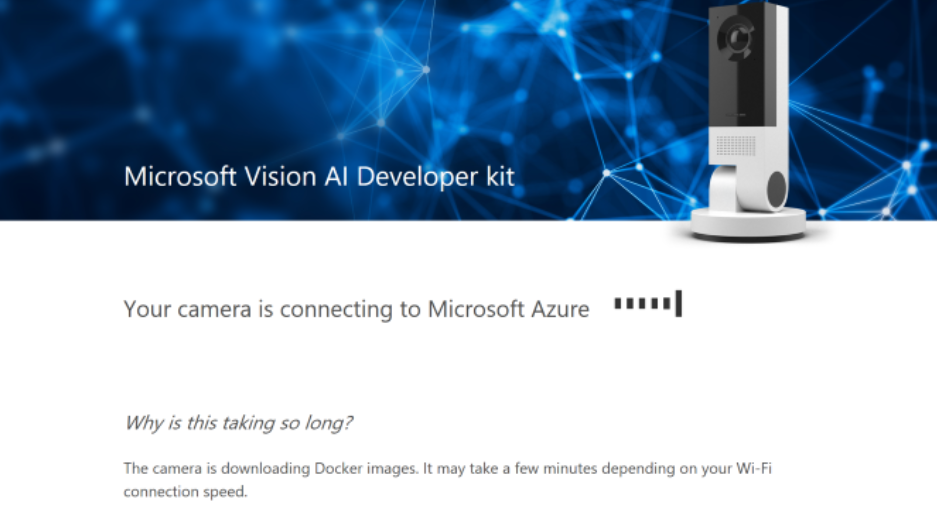

## 1. Making Model building easy and accesable to all

### Upload you training images 

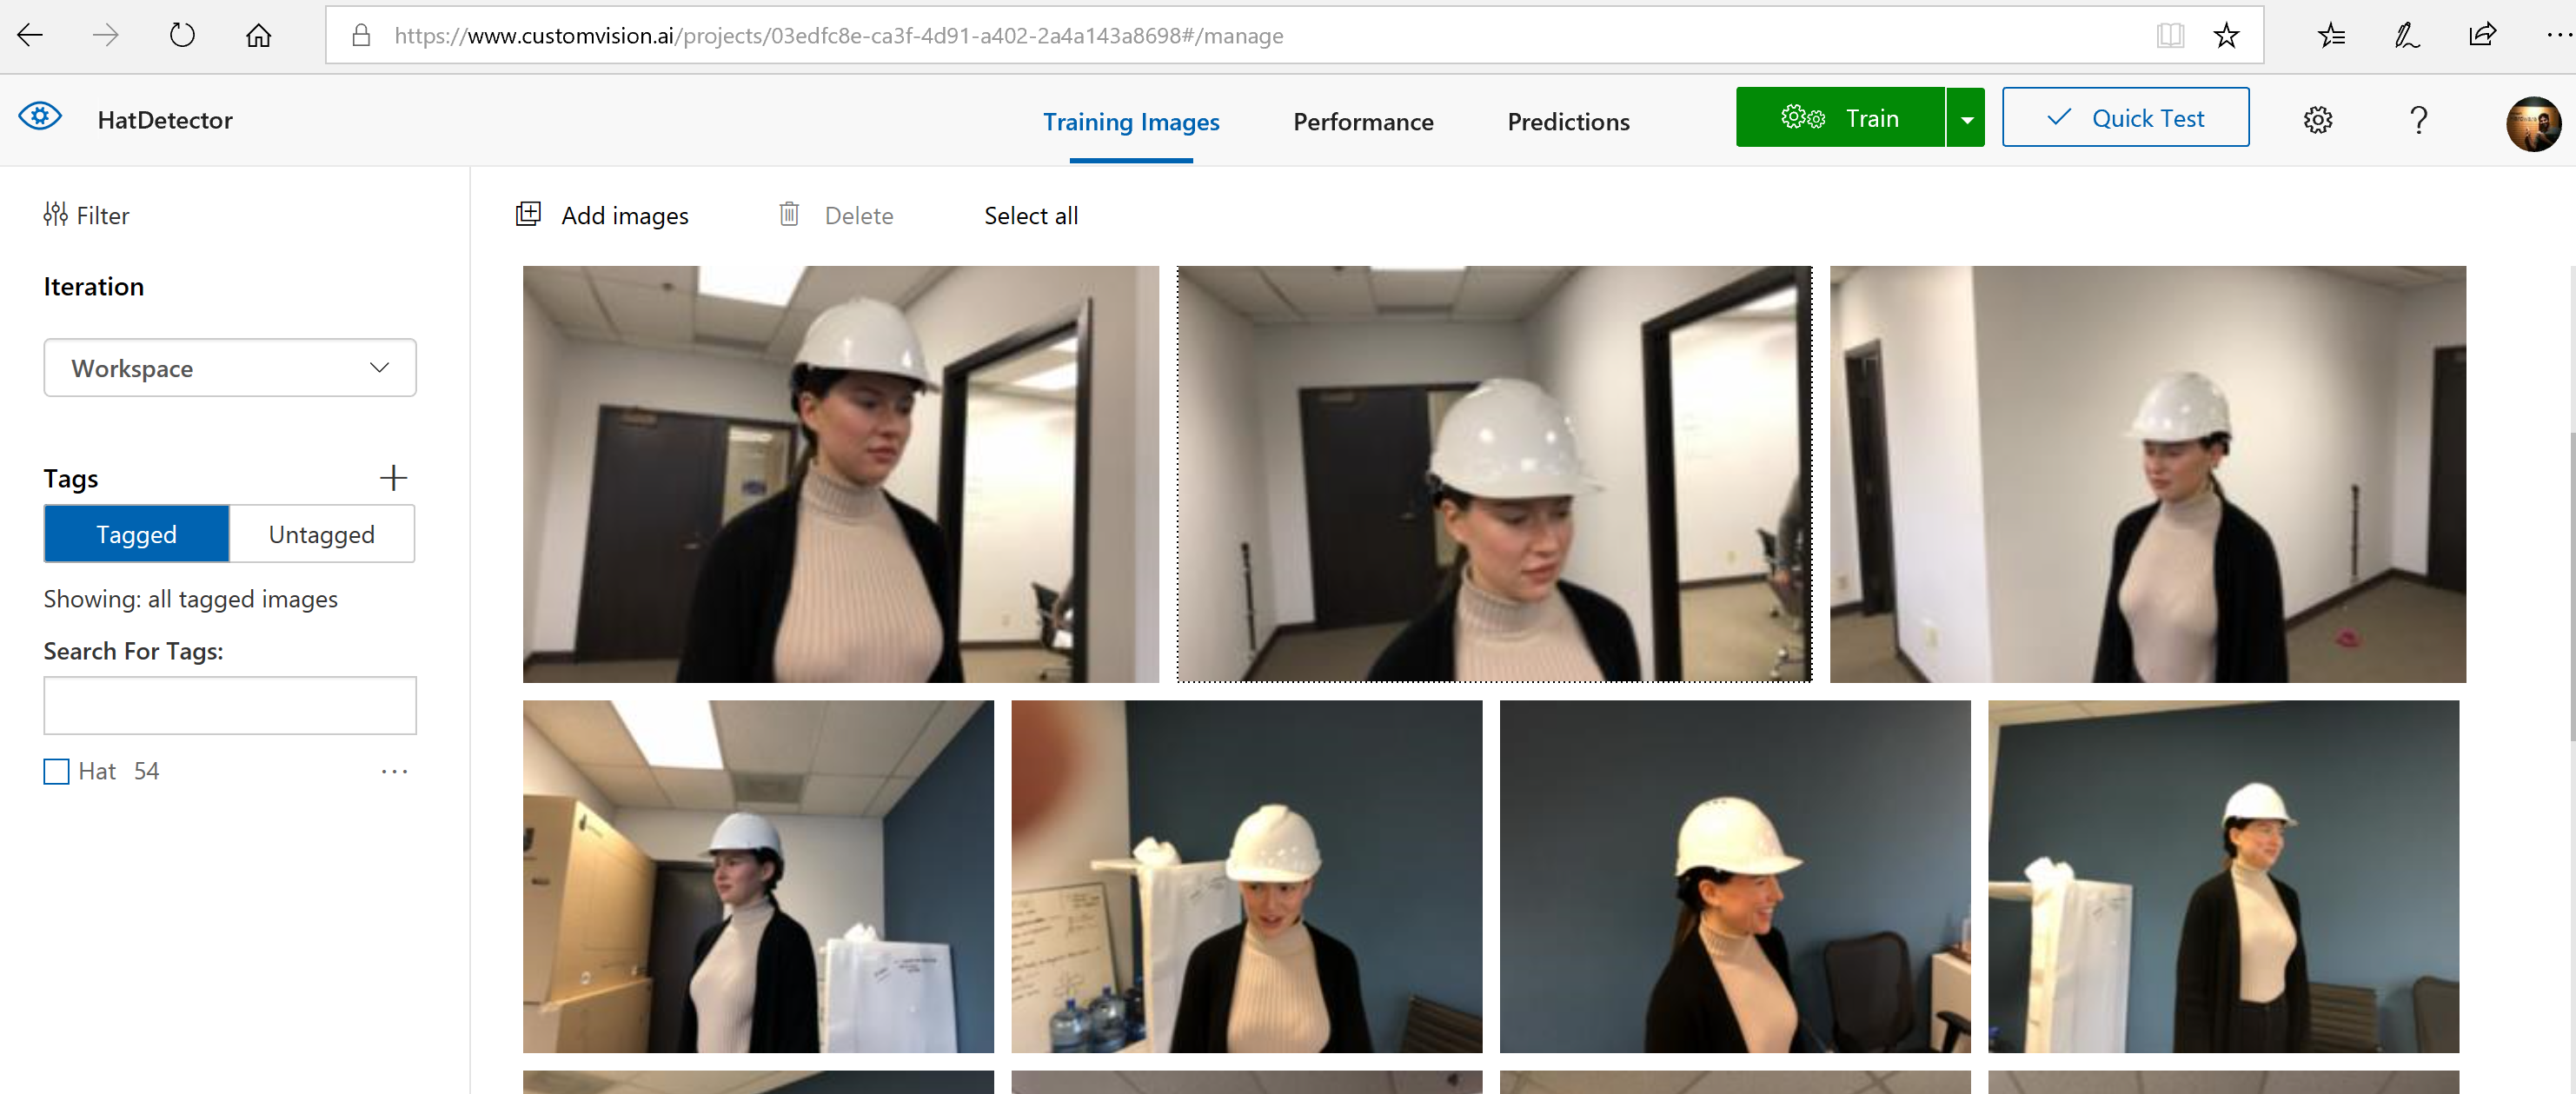

### Train and download your model that is it 

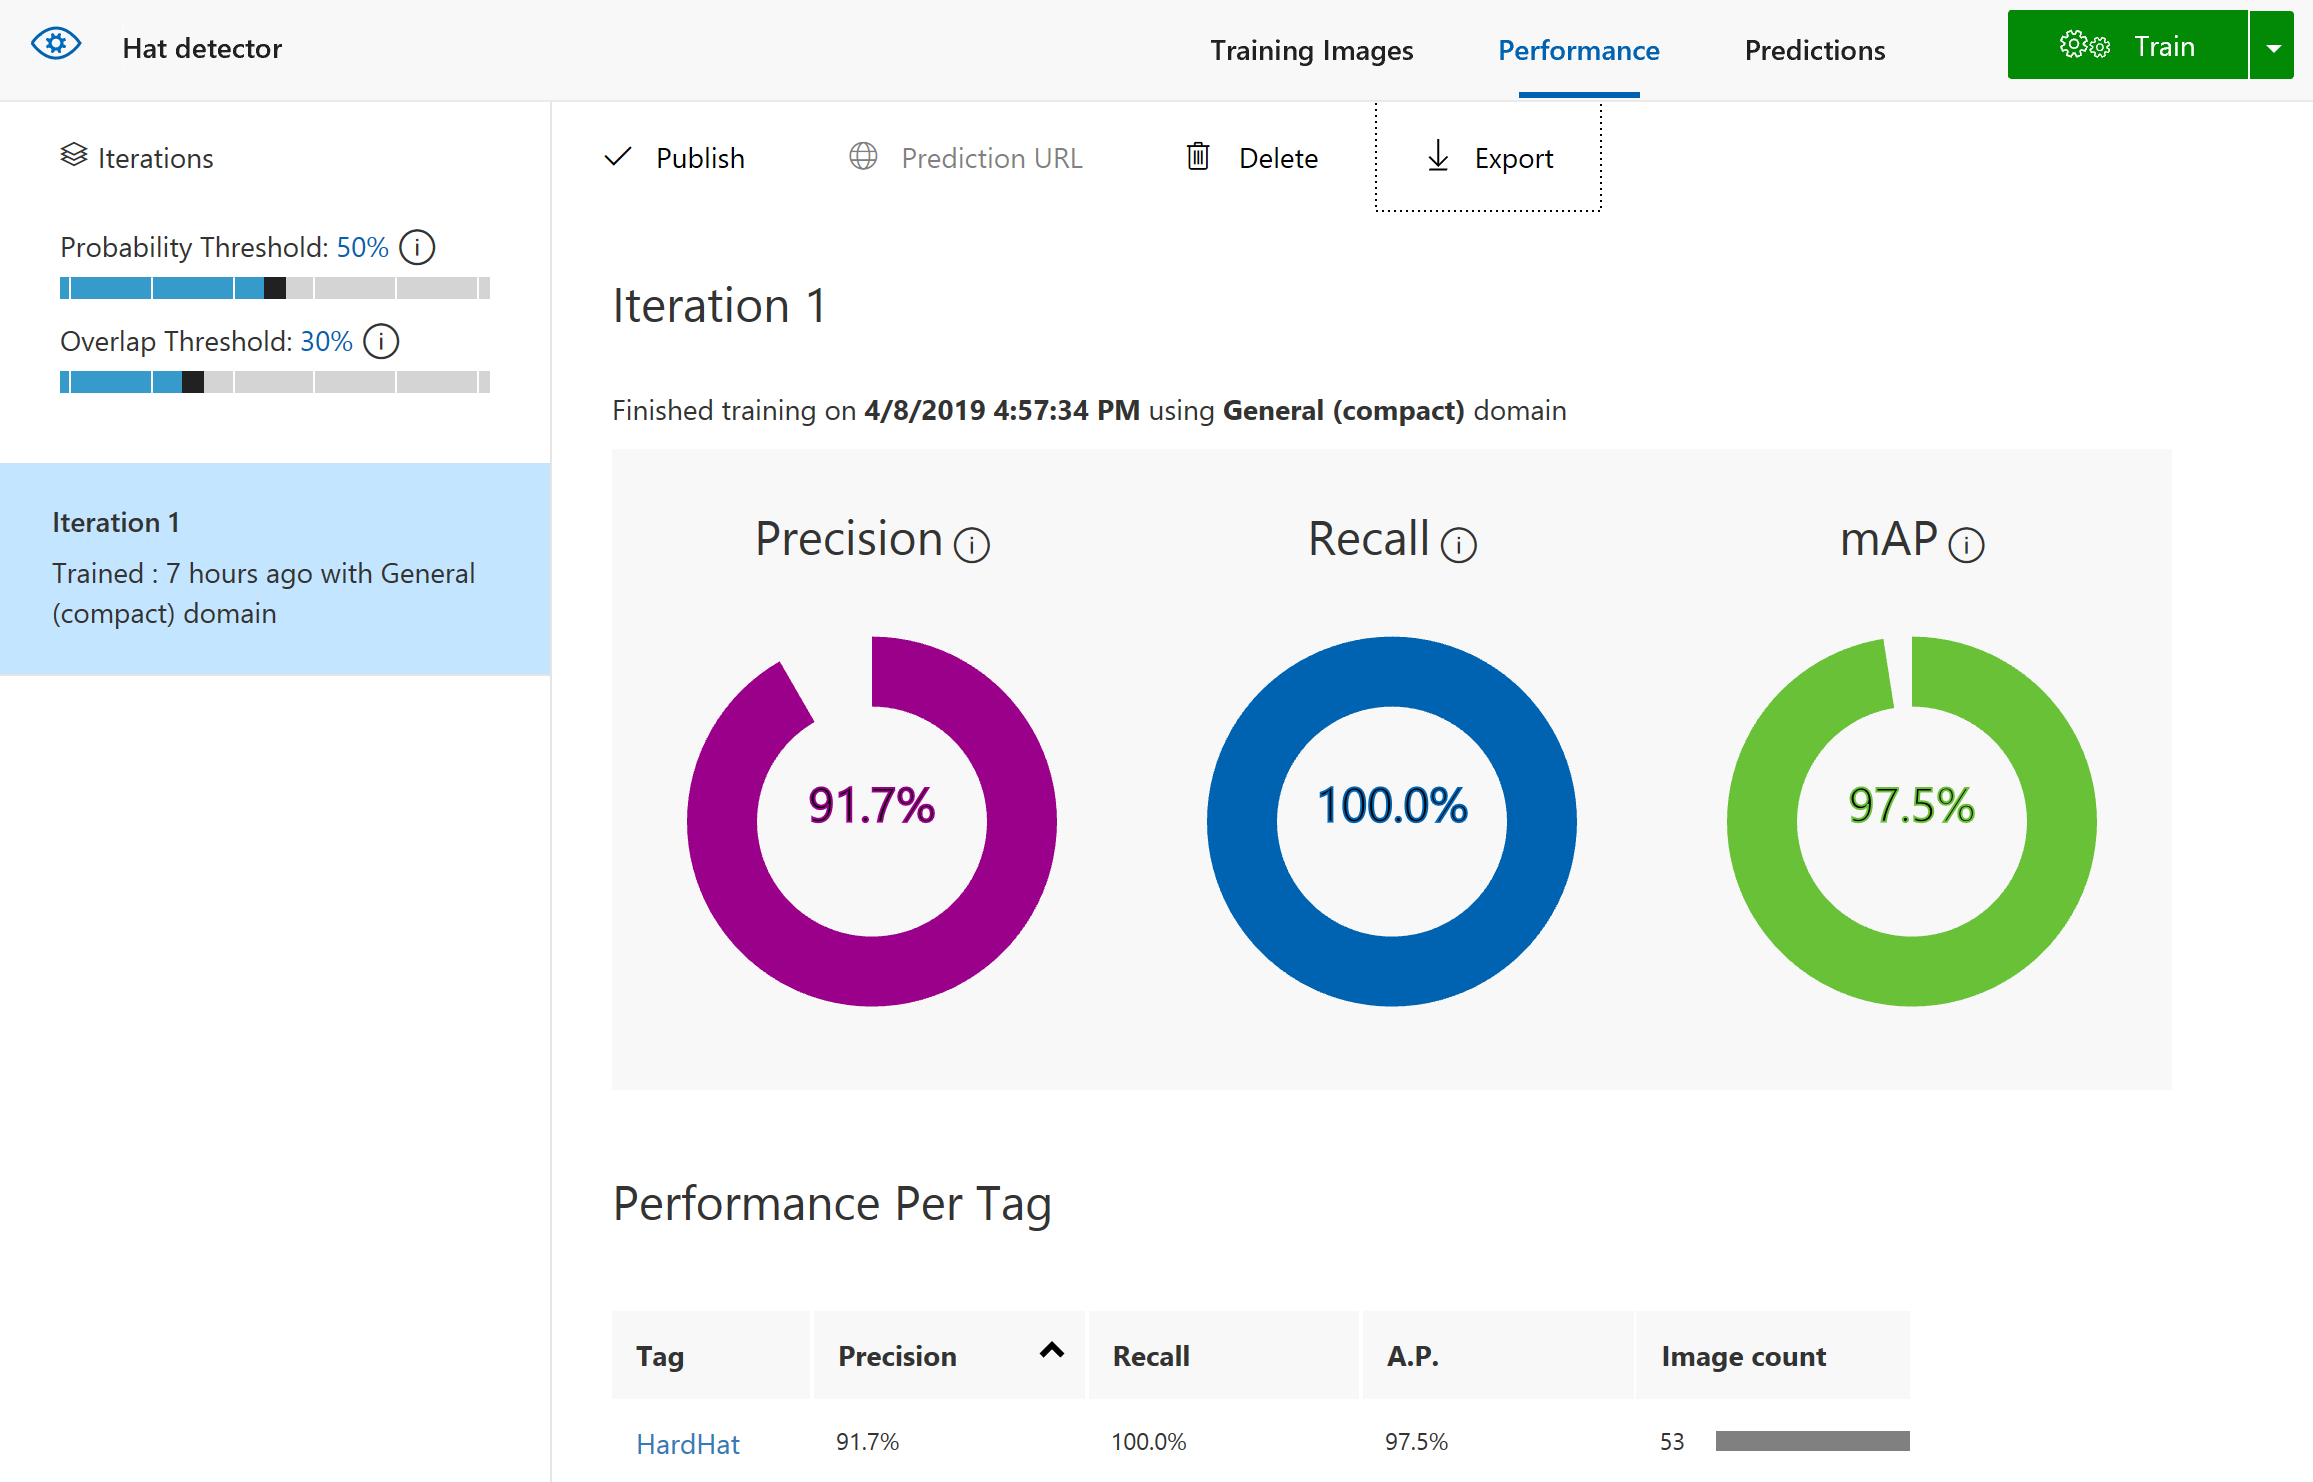

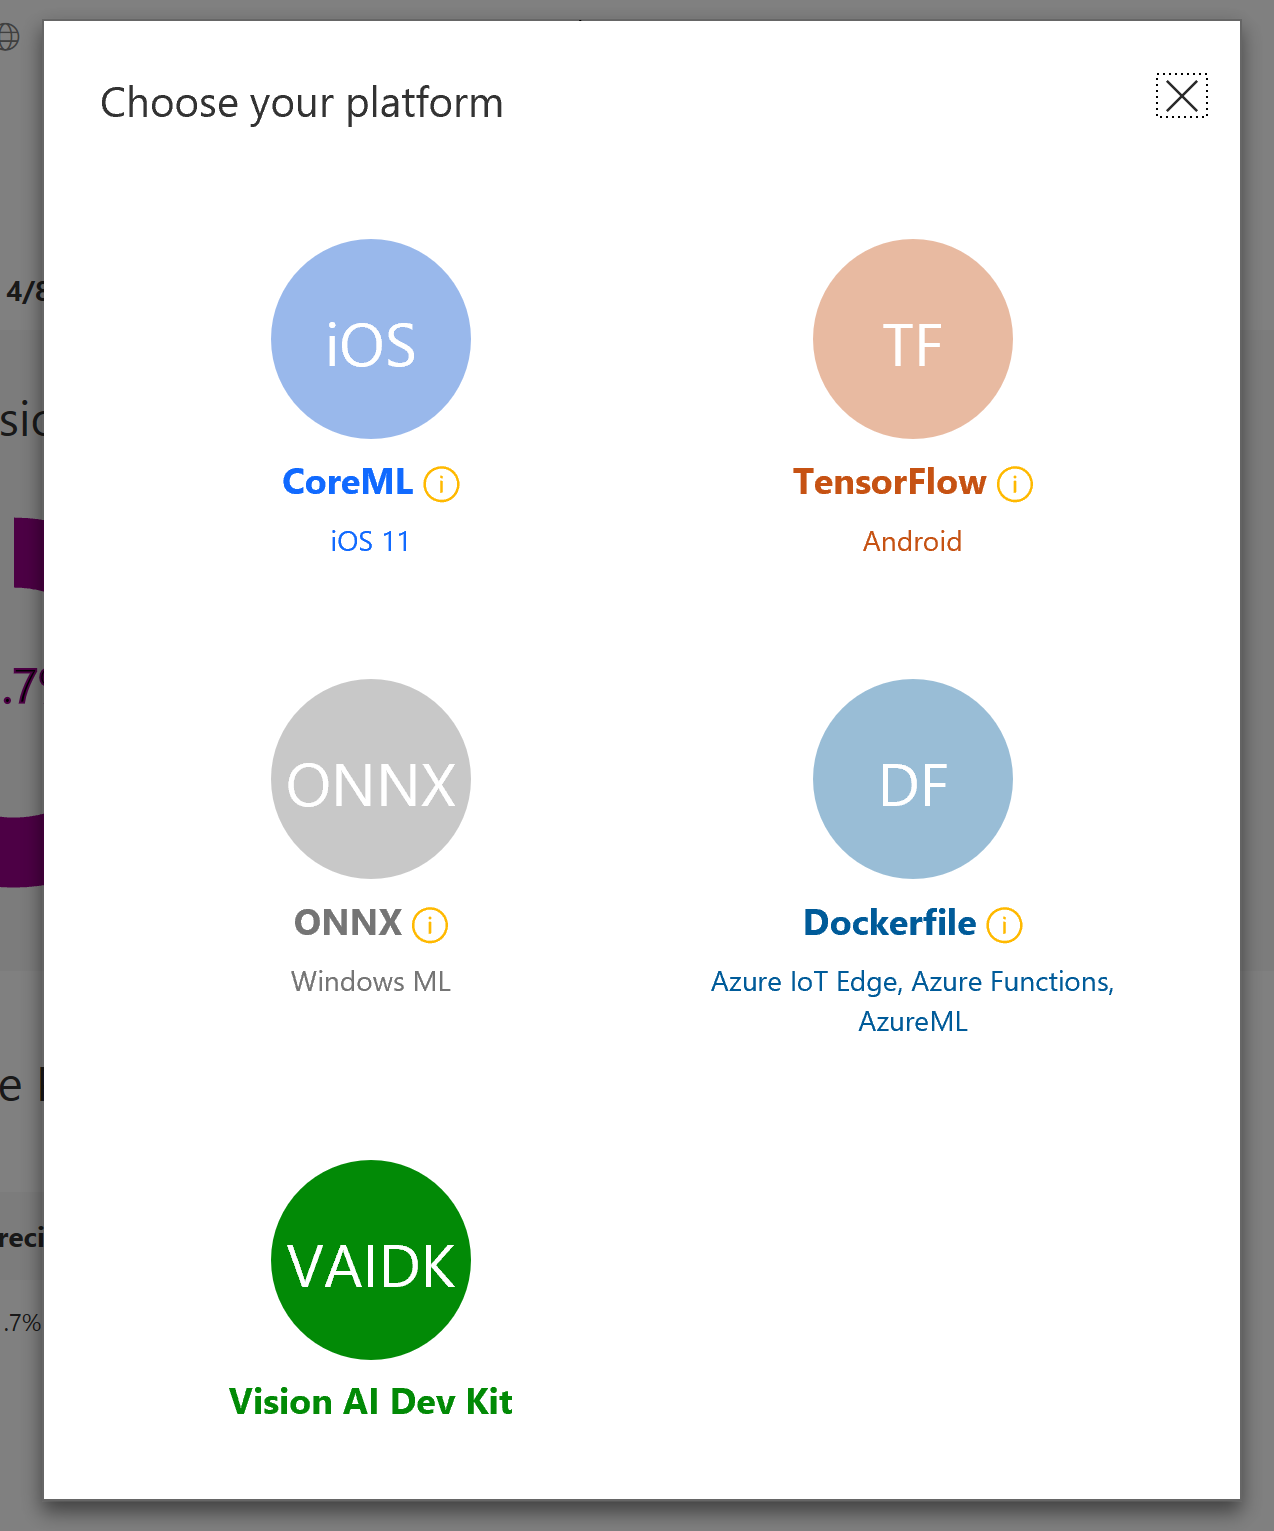

## 2. Register Your Model to Azure Machine Learning Service to track and Manage

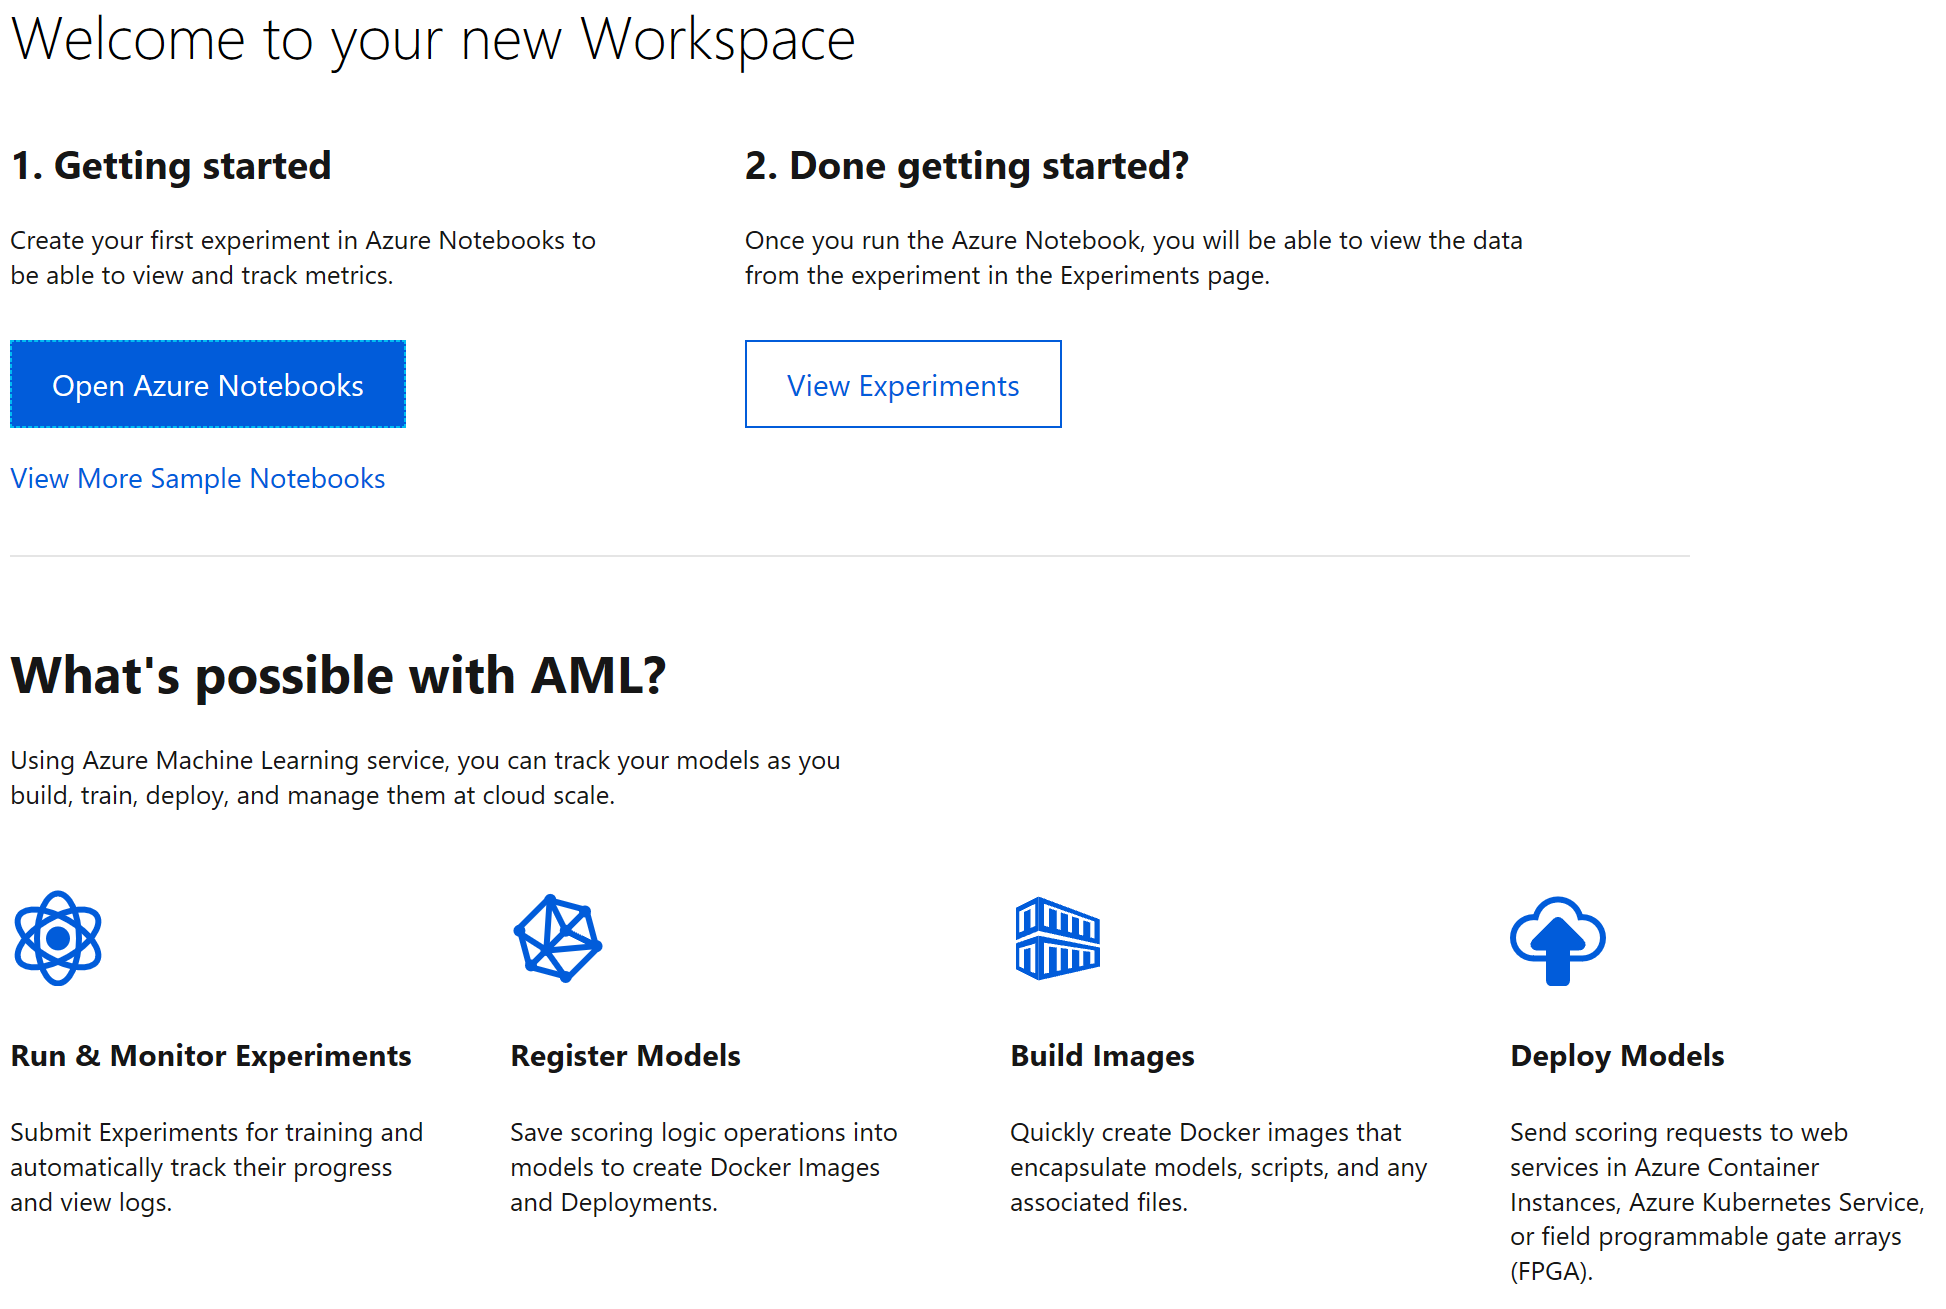

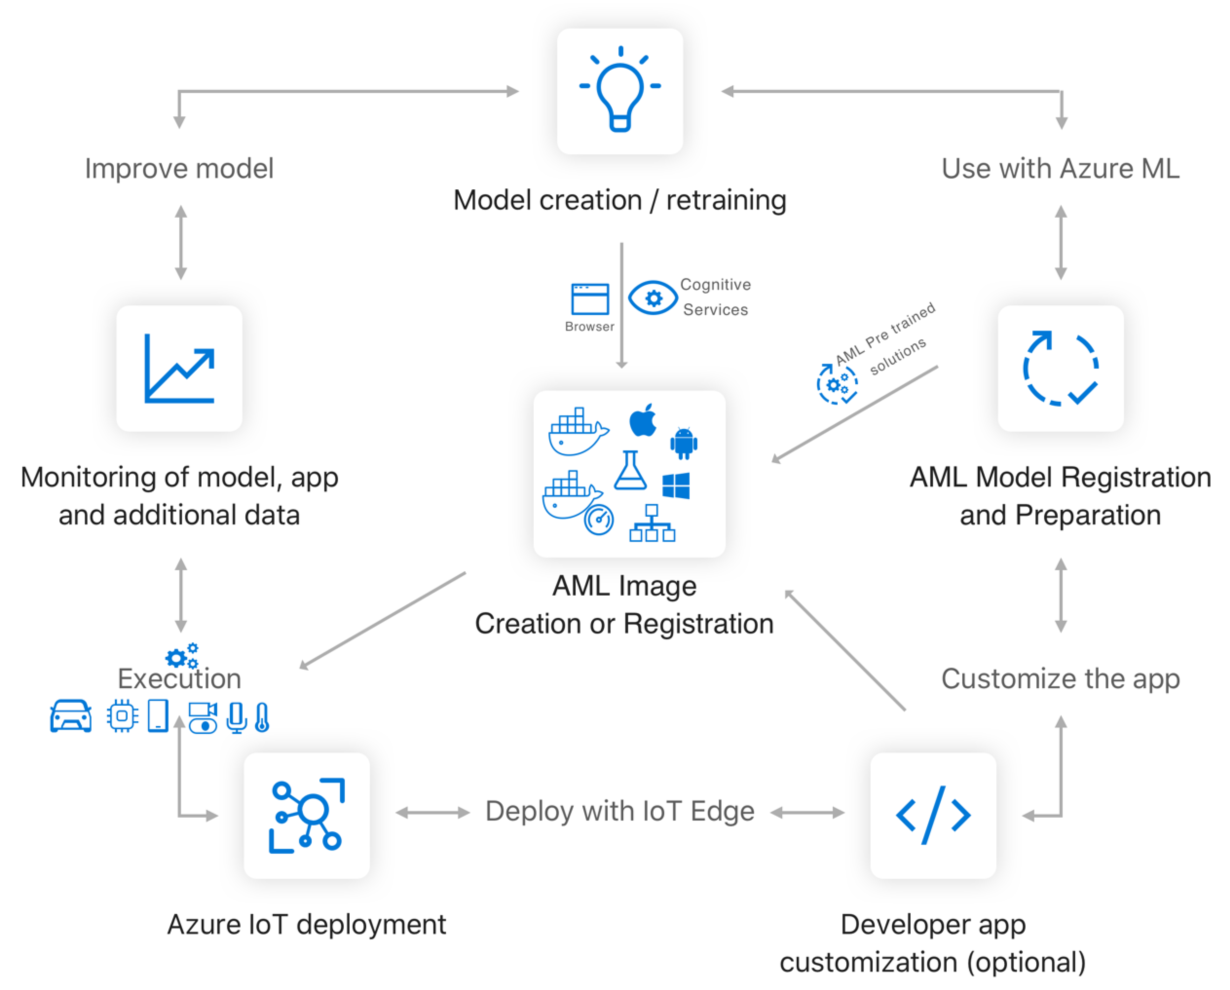

In [1]:
# For prod
!pip install azureml-core
!pip install azureml-contrib-iot --user
!pip install azure-mgmt-containerregistry   

In [2]:
import os
print(os.__file__)

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\os.py


In [3]:
# Check core SDK version number
import azureml.core as azcore

print("SDK version:", azcore.VERSION)

SDK version: 1.0.23


### Create a Workspace
#### Change this cell from markdown to code and run this if you need to create a workspace 
#### Update the values for your workspace below
ws=Workspace.create(subscription_id="replace-with-subscription-id",
                resource_group="your-resource-group",
                name="your-workspace-name",
                location="eastus2")
                
ws.write_config()

In [4]:
#Initialize Workspace 
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Found the config file in: C:\Users\yadavm\Source\Repos\vision-ai-developer-kit\machine-learning-reference\notebooks\aml_config\config.json
myworkspaceeastus
myamltest
eastus
6b7899d1-12ae-44f8-bc66-221deb938d54


### Register model
Download the model files from customvision.ai.

In [7]:
from azureml.core.model import Model

model = Model.register(model_path = "models/squeezenet-HardHat/orig",#"models/squeezenet-forks/orig/",
                      model_name = "HardHatDetector",
                      tags = {"data": "customvision", "model": "object_detection", "type": "squeezenet"},
                      description = "Trained HardHadDetector based on Squeezenet",
                      workspace = ws)
print(model.name, model.url, model.version, model.id, model.created_time)

Registering model HardHatDetector
HardHatDetector aml://asset/33b6da05b89649efa33a46caa0eb8e0b 3 HardHatDetector:3 2019-04-09 06:08:54.966816+00:00


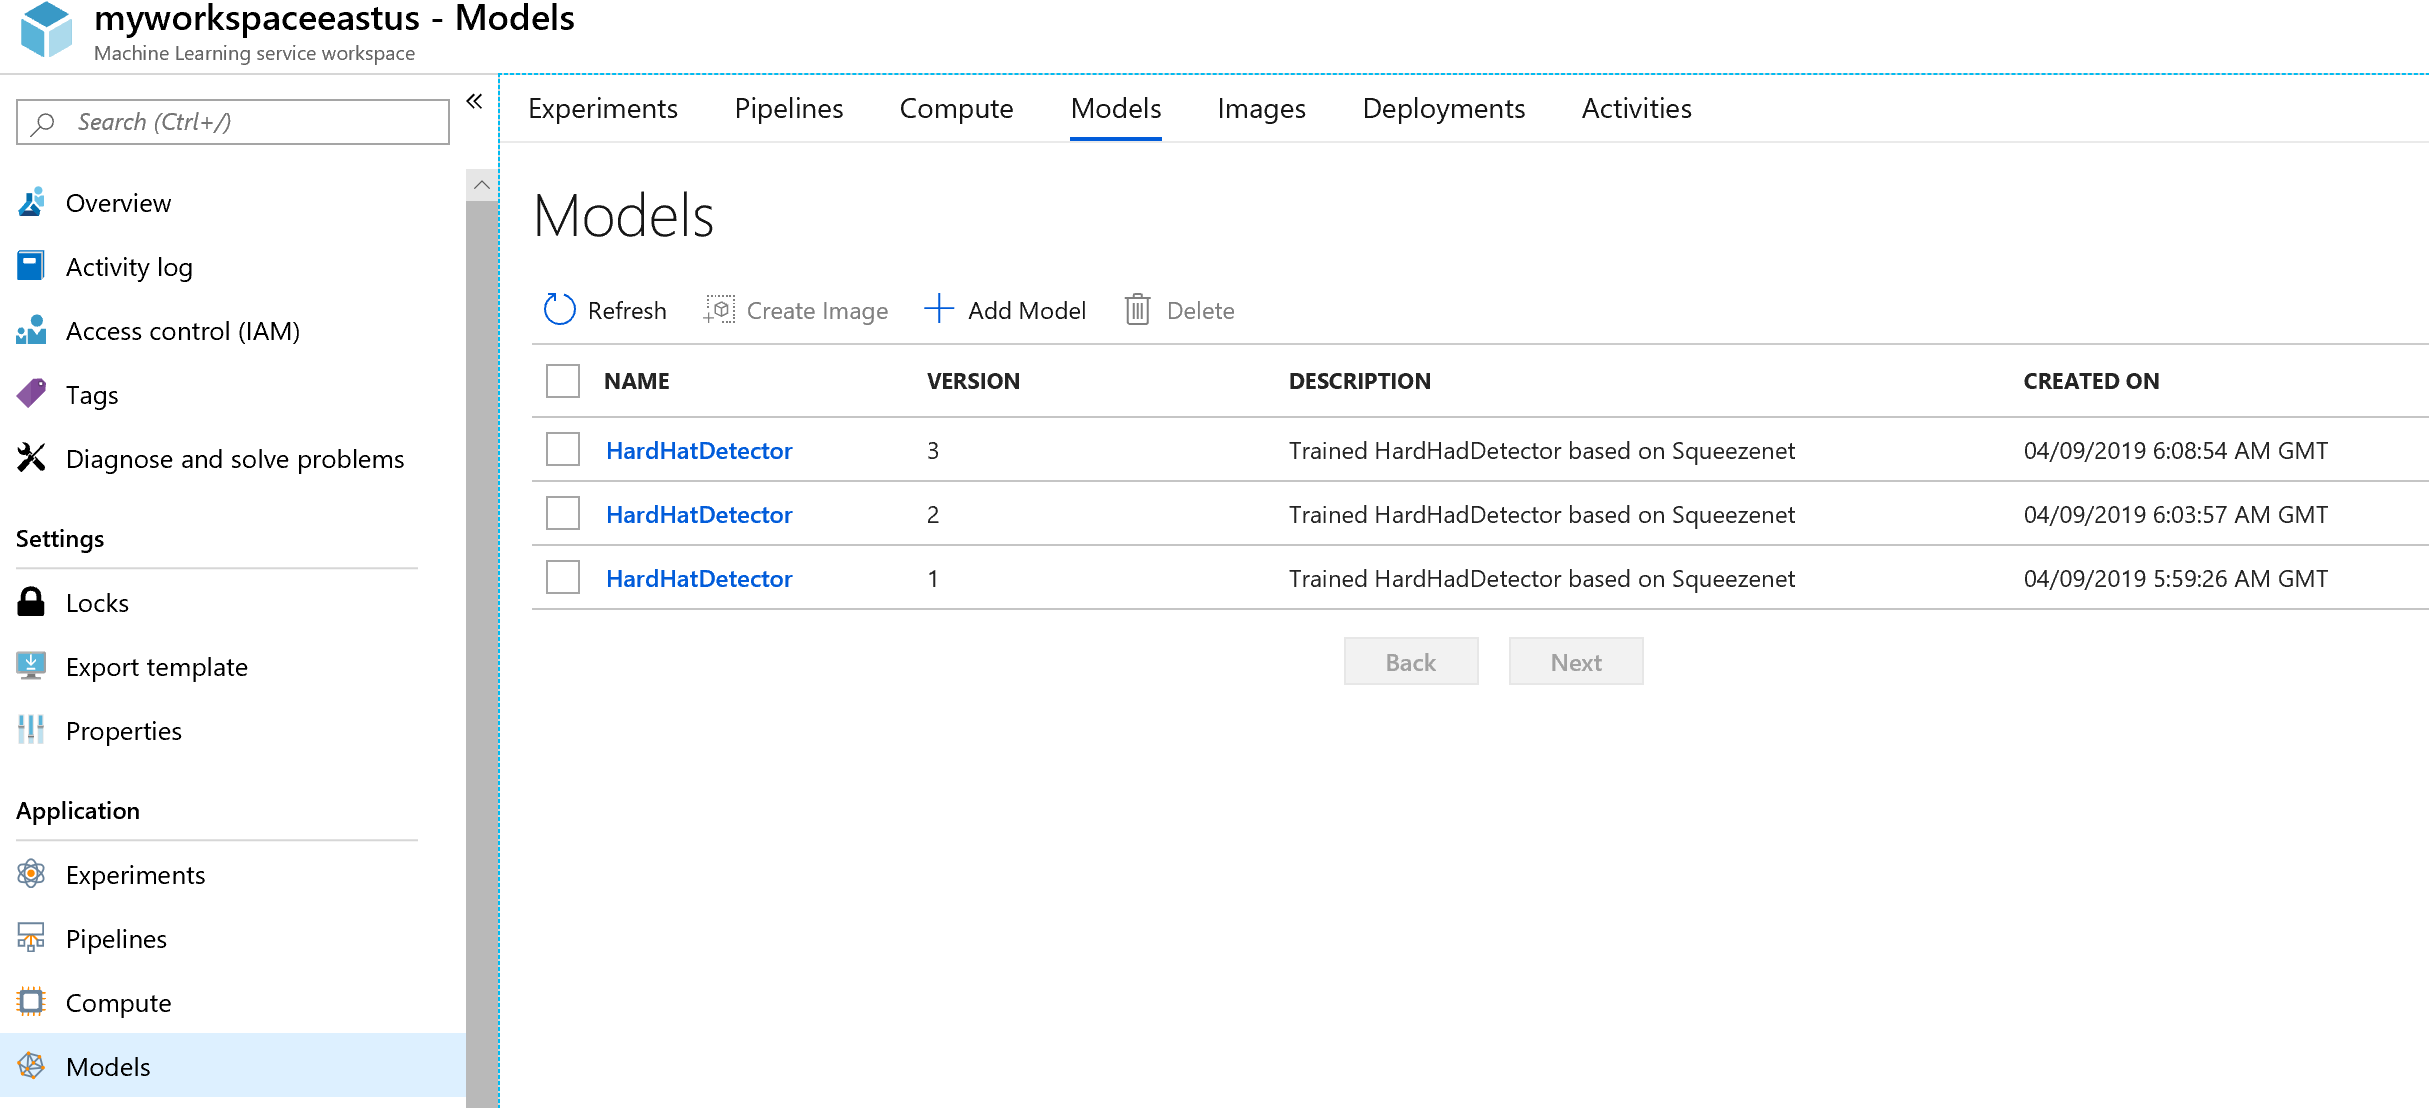

from azureml.contrib.iot.model_converters import SnpeConverter

# submit a compile request
compile_request = SnpeConverter.convert_caffe_model(
    ws,
    source_model=model,
    mirror_content = True)
print(compile_request._operation_id)

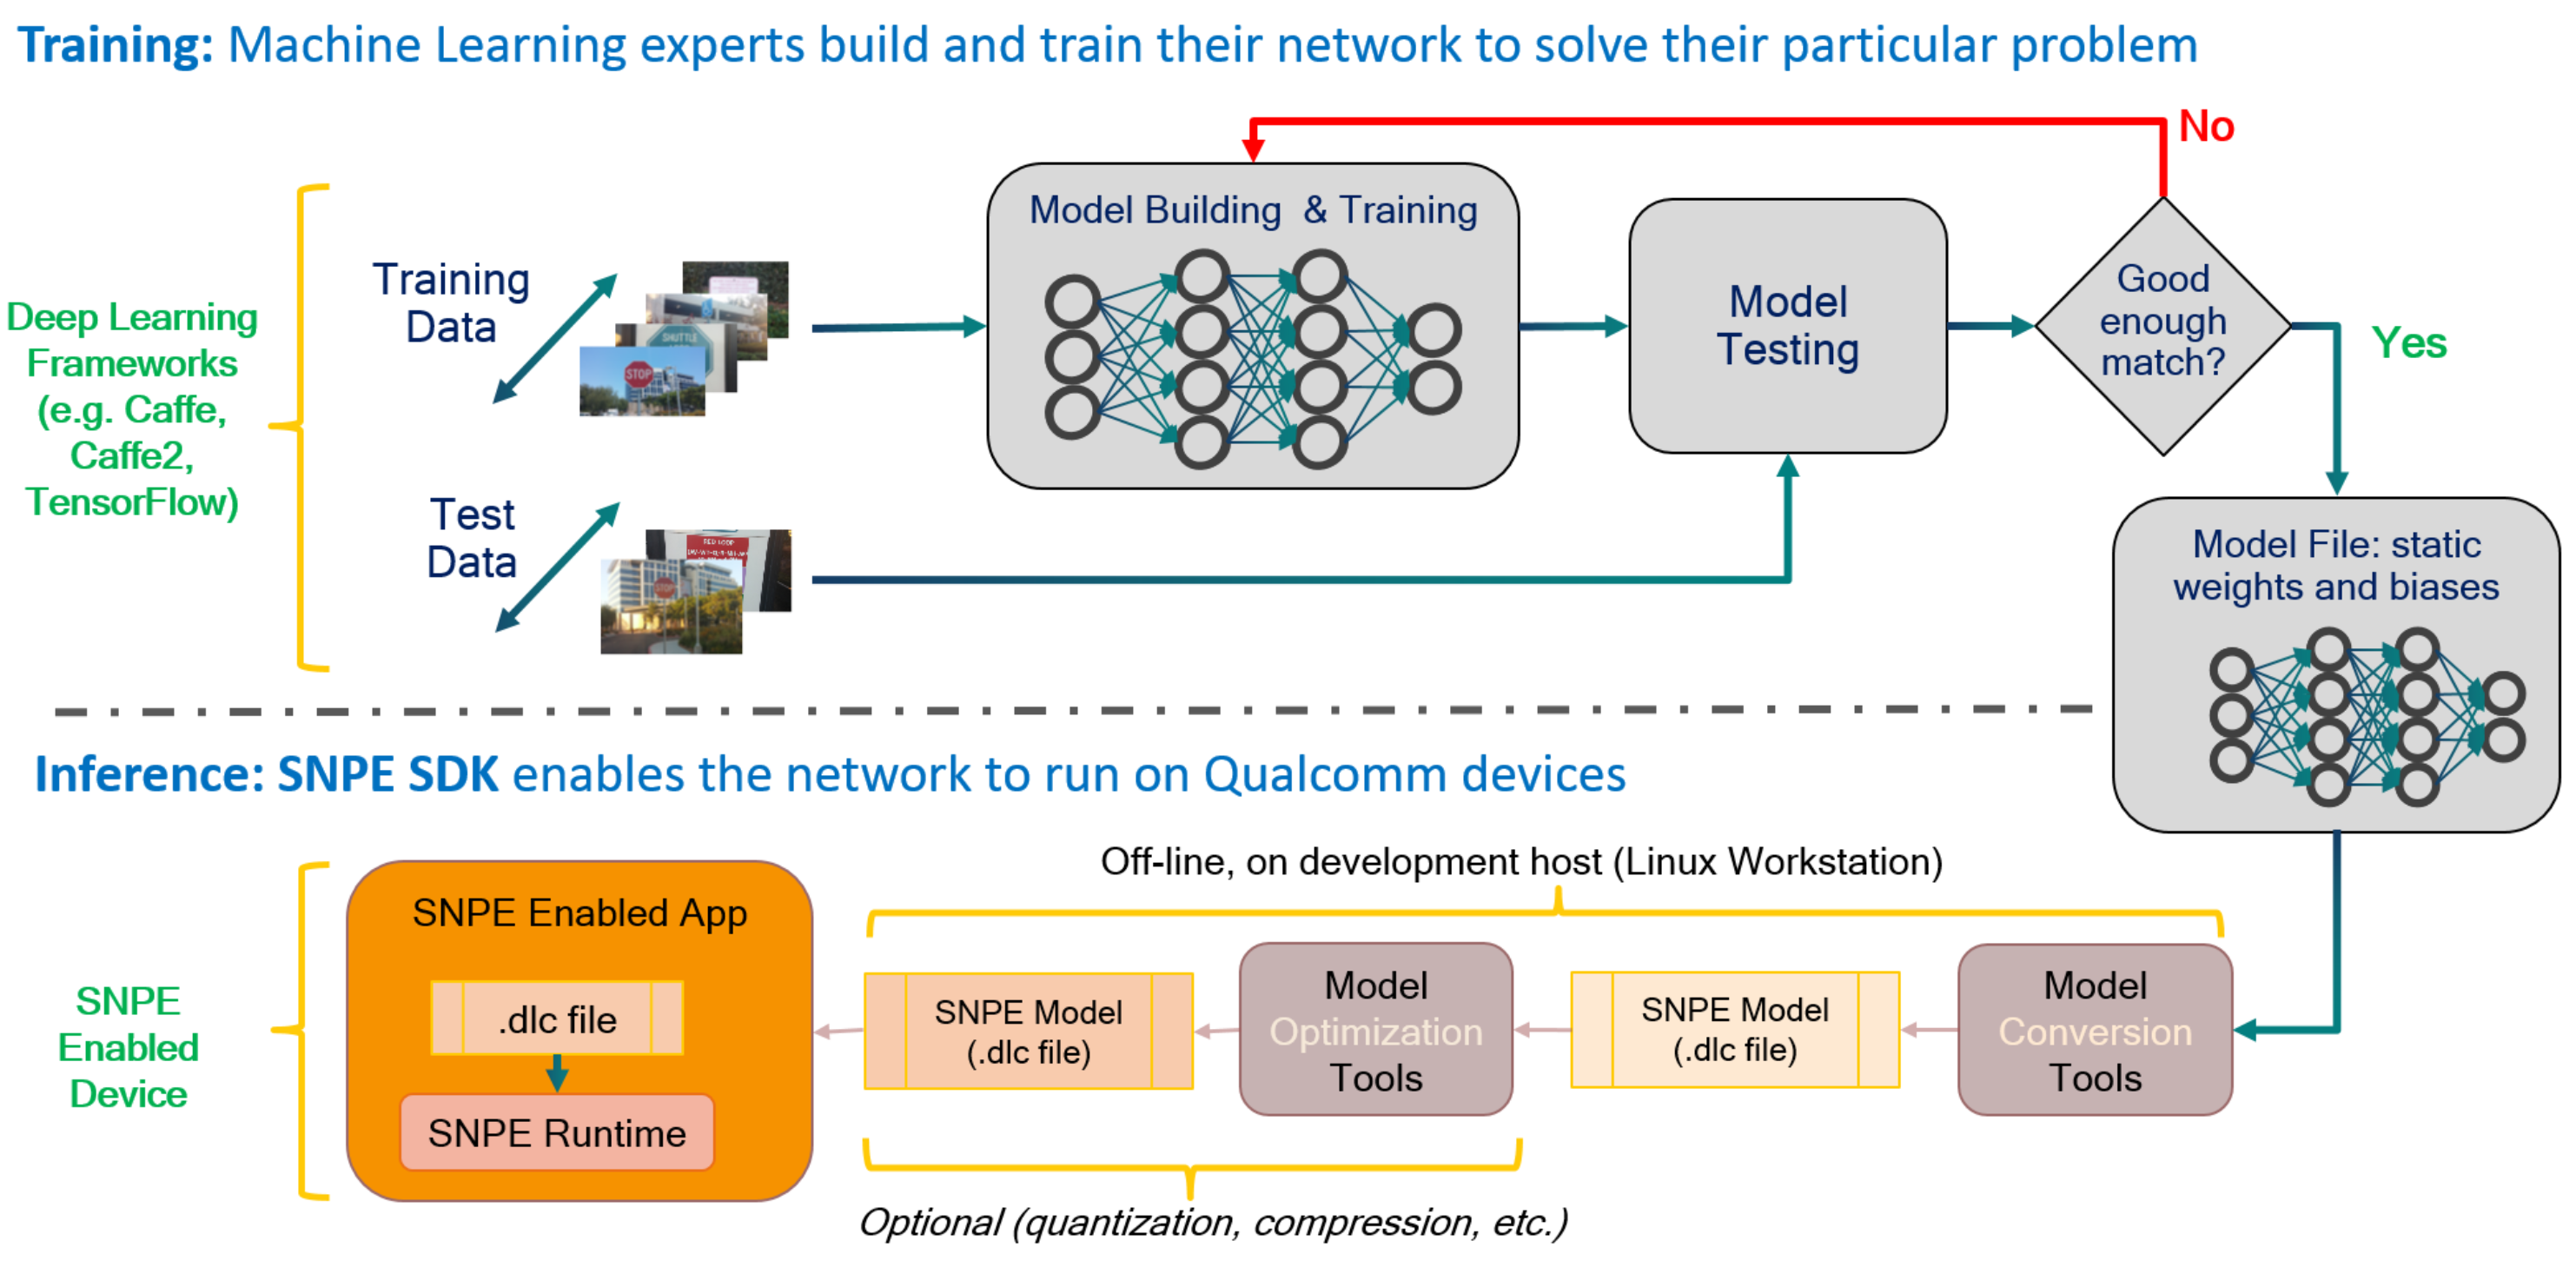

# wait for the request to complete
compile_request.wait_for_completion(show_output=True)

# Get converted model
converted_model = compile_request.result
print(converted_model.name, converted_model.url, converted_model.version, converted_model.id, converted_model.created_time)

In [9]:
from azureml.core.image import Image
from azureml.contrib.iot import IotContainerImage
print ('We will create an image for you now ...')
image_config = IotContainerImage.image_configuration(
                                 architecture="arm32v7",
                                 execution_script="main.py", 
                                 dependencies=["camera.py","iot.py","ipcprovider.py","utility.py", "frame_iterators.py"],
                                 docker_file="Dockerfile", 
                                 tags = ["squeezenet"],
                                 description = "Squeezenet model from customvision.ai")
image = Image.create(name = "hardhat",
                     # this is the model object 
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)
image.wait_for_creation(show_output = True)

We will create an image for you now ...
Creating image
Running...............................................................................................................................................................................................
SucceededImage creation operation finished for image hardhat:1, operation "Succeeded"


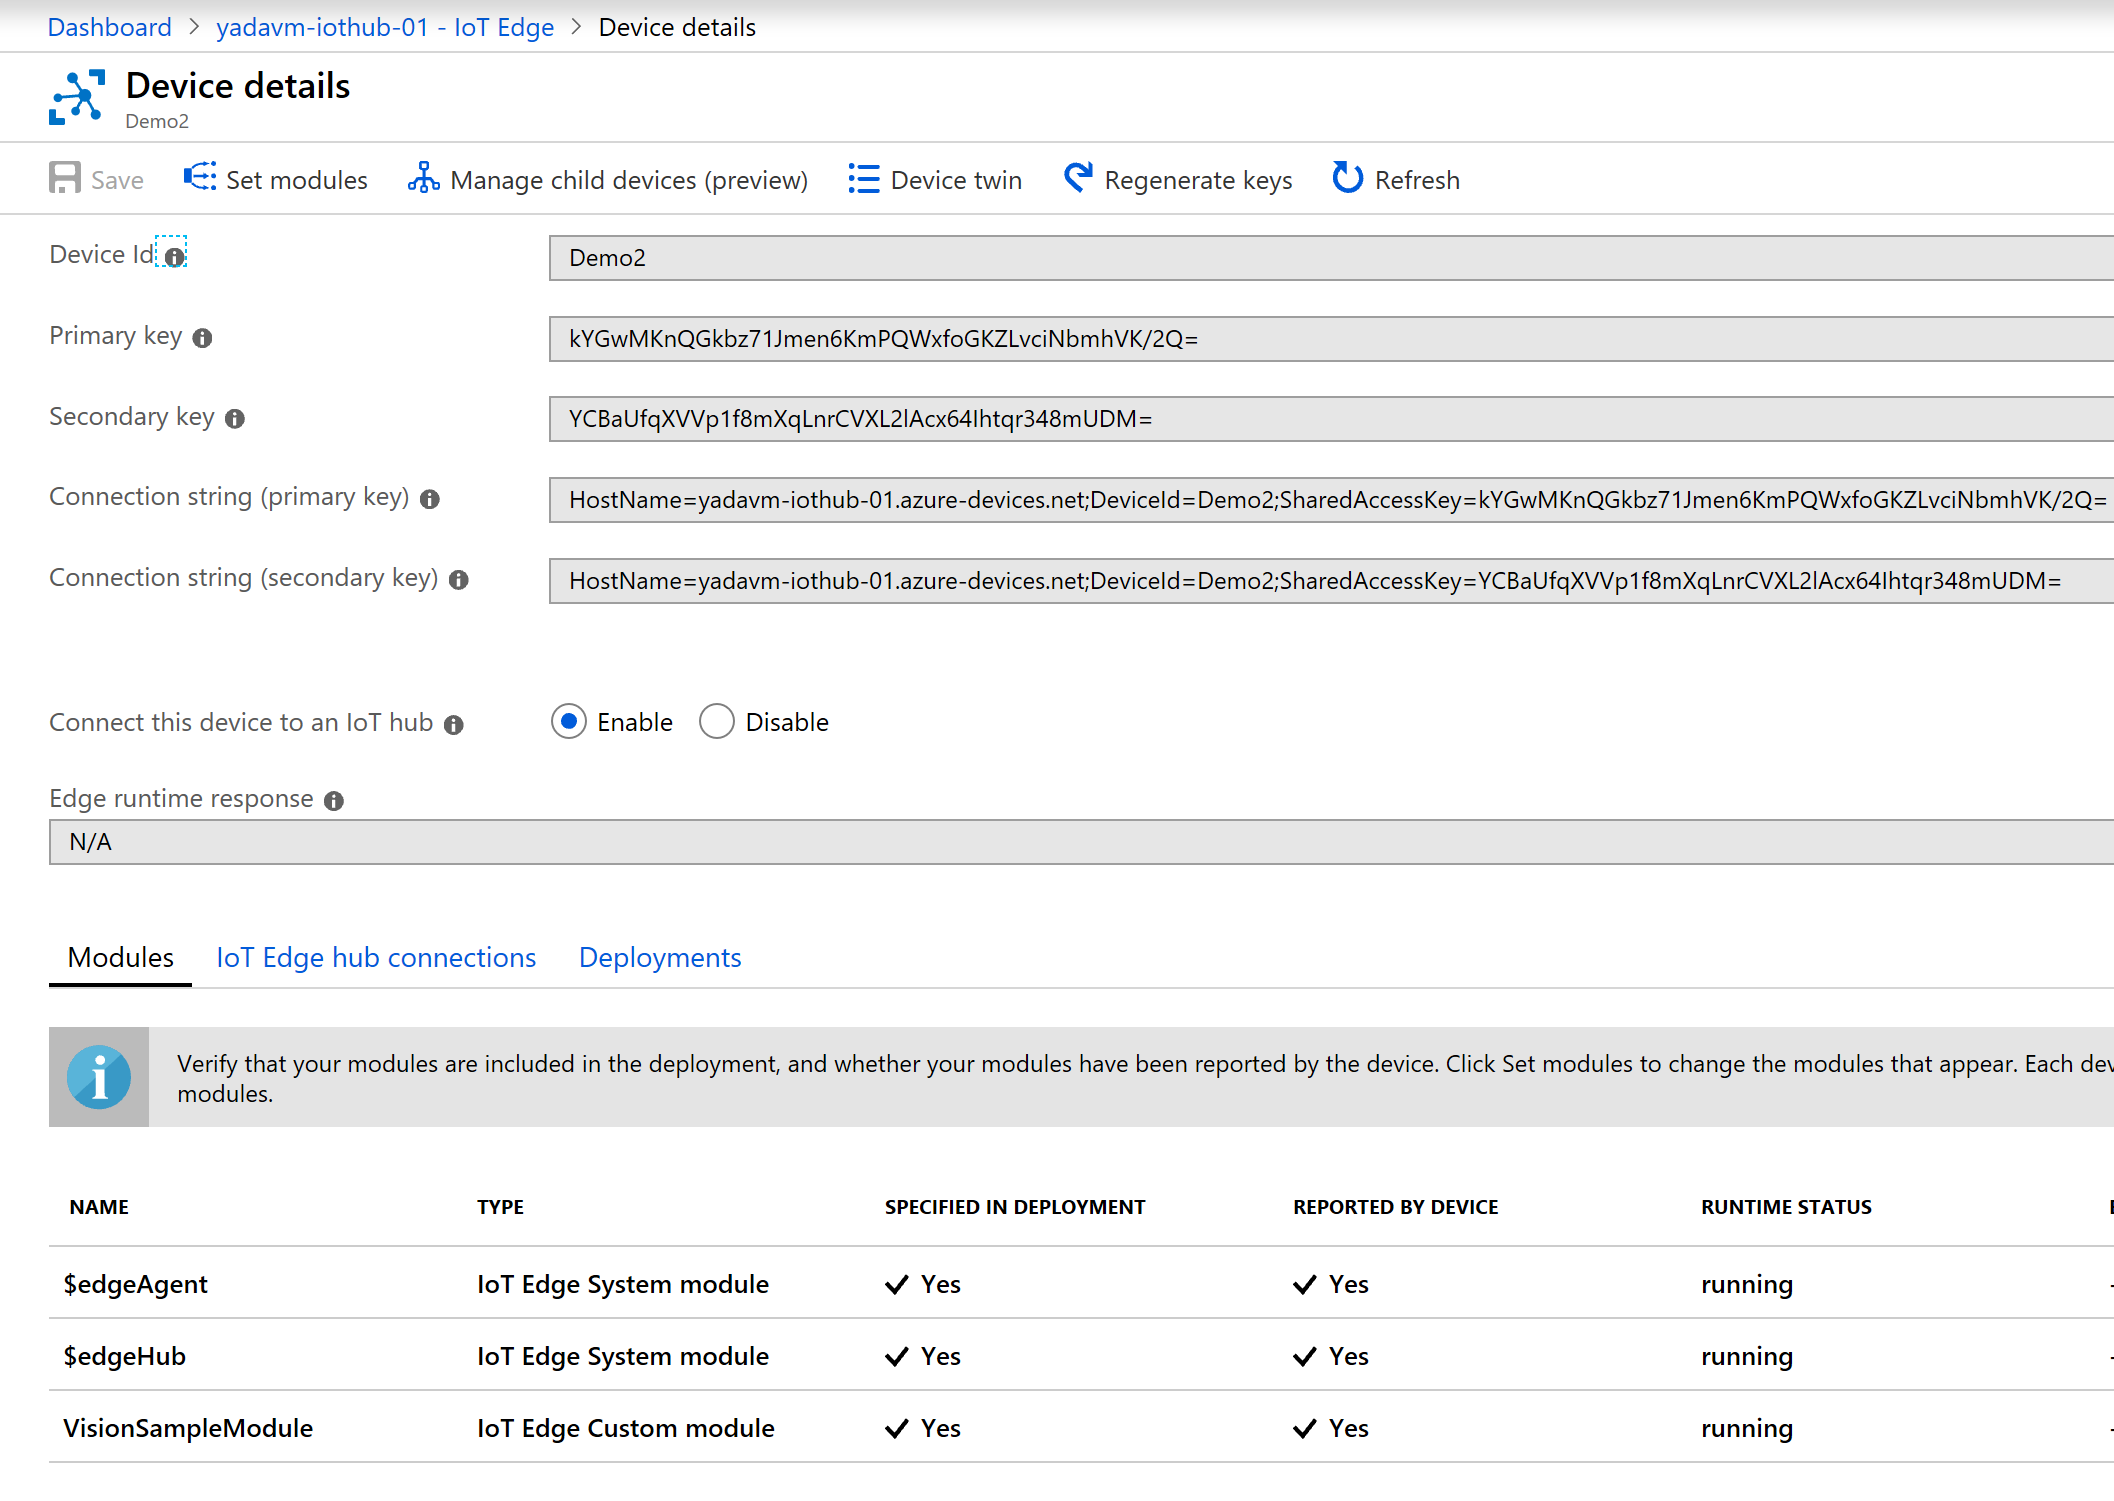

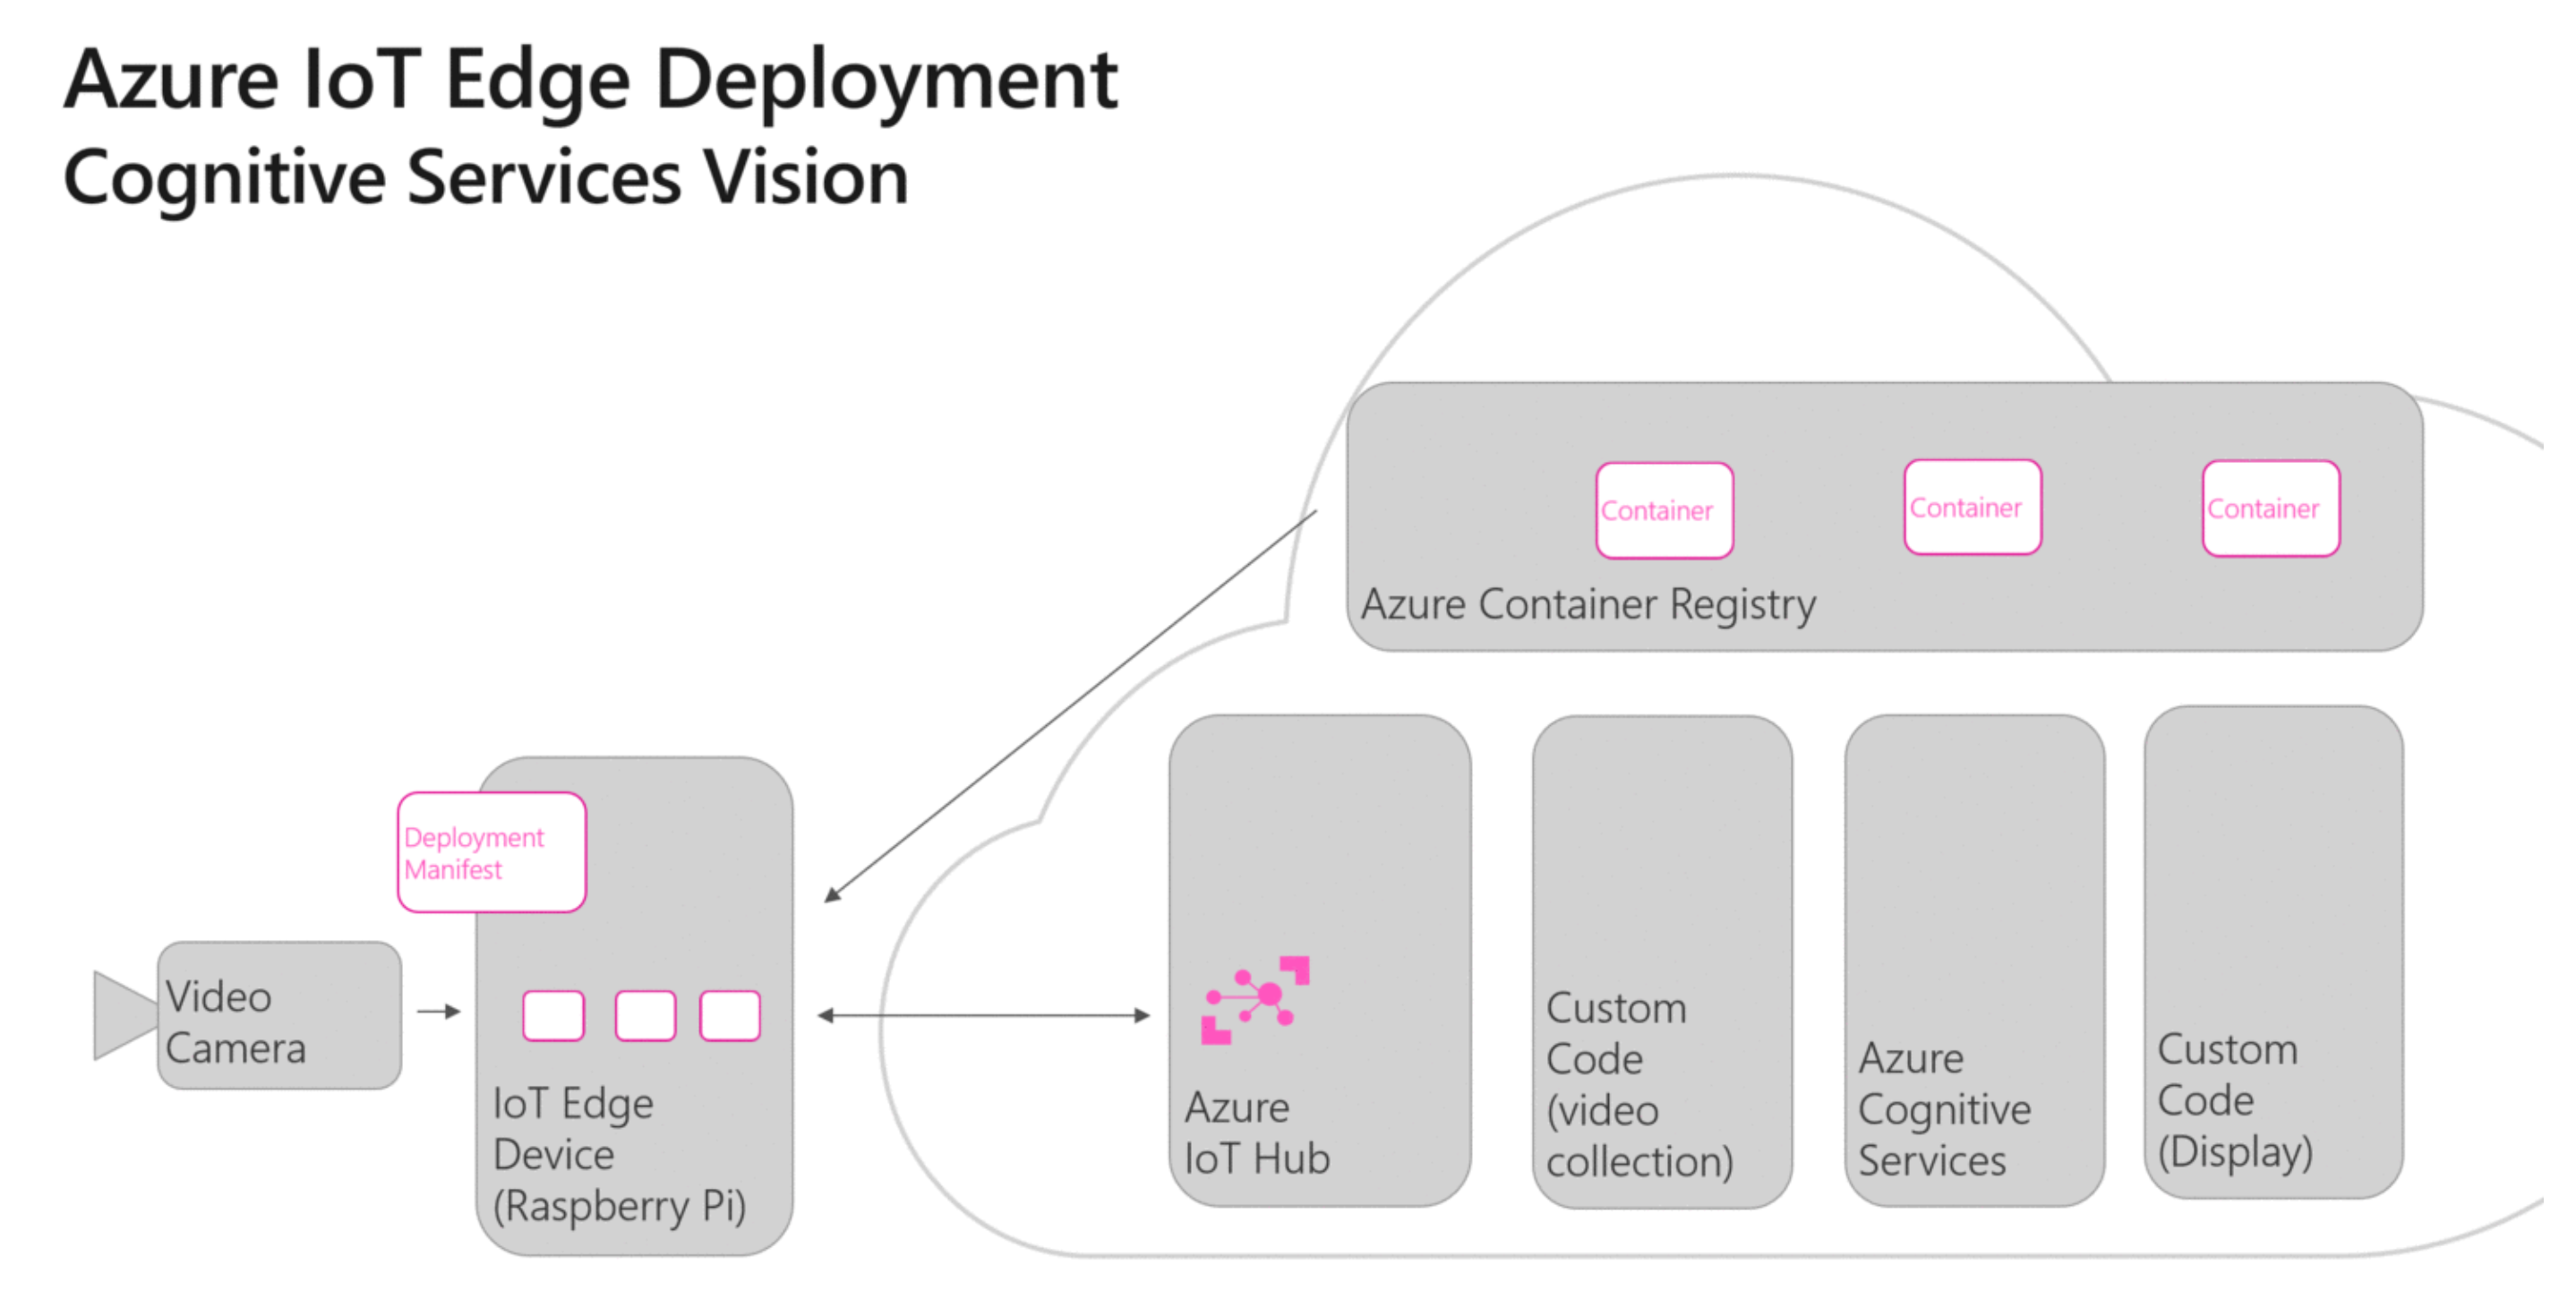

In [ ]:
# Parameter list

# Pick a name for what you want to call the module you deploy to the camera
module_name = "visionsample"

# Resource group in Azure 
resource_group_name= ws.resource_group
iot_rg="vaidk_"+resource_group_name

# Azure region where your services will be provisioned
iot_location="eastus2"

# Azure IoT Hub name
iot_hub_name="iothub-"+ ws.get_details()["name"]

# Pick a name for your cameraiot_device_id="vadik_"+ ws.get_details()["name"]

# Pick a name for the deployment configuration
iot_deployment_id="demovaidk"

In [ ]:
# Getting your container details
container_reg = ws.get_details()["containerRegistry"]
reg_name=container_reg.split("/")[-1]
container_url = "\"" + image.image_location + "\","
subscription_id = ws.subscription_id
print('{}'.format(image.image_location))
print('{}'.format(reg_name))
print('{}'.format(subscription_id))
from azure.mgmt.containerregistry import ContainerRegistryManagementClient
from azure.mgmt import containerregistry
client = ContainerRegistryManagementClient(ws._auth,subscription_id)
result= client.registries.list_credentials(resource_group_name, reg_name, custom_headers=None, raw=False)
username = result.username
password = result.passwords[0].value

### Deployment file
This is the deployment.json file that you will use to deploy your model.  Please see the other sample notebooks on using this file to deploy the new model you created.

In [ ]:
file = open('./deployment-template.json')
contents = file.read()
contents = contents.replace('__MODULE_NAME', module_name)
contents = contents.replace('__REGISTRY_NAME', reg_name)
contents = contents.replace('__REGISTRY_USER_NAME', username)
contents = contents.replace('__REGISTRY_PASSWORD', password)
contents = contents.replace('__REGISTRY_IMAGE_LOCATION', image.image_location)
with open('./deployment.json', 'wt', encoding='utf-8') as output_file:
    output_file.write(contents)

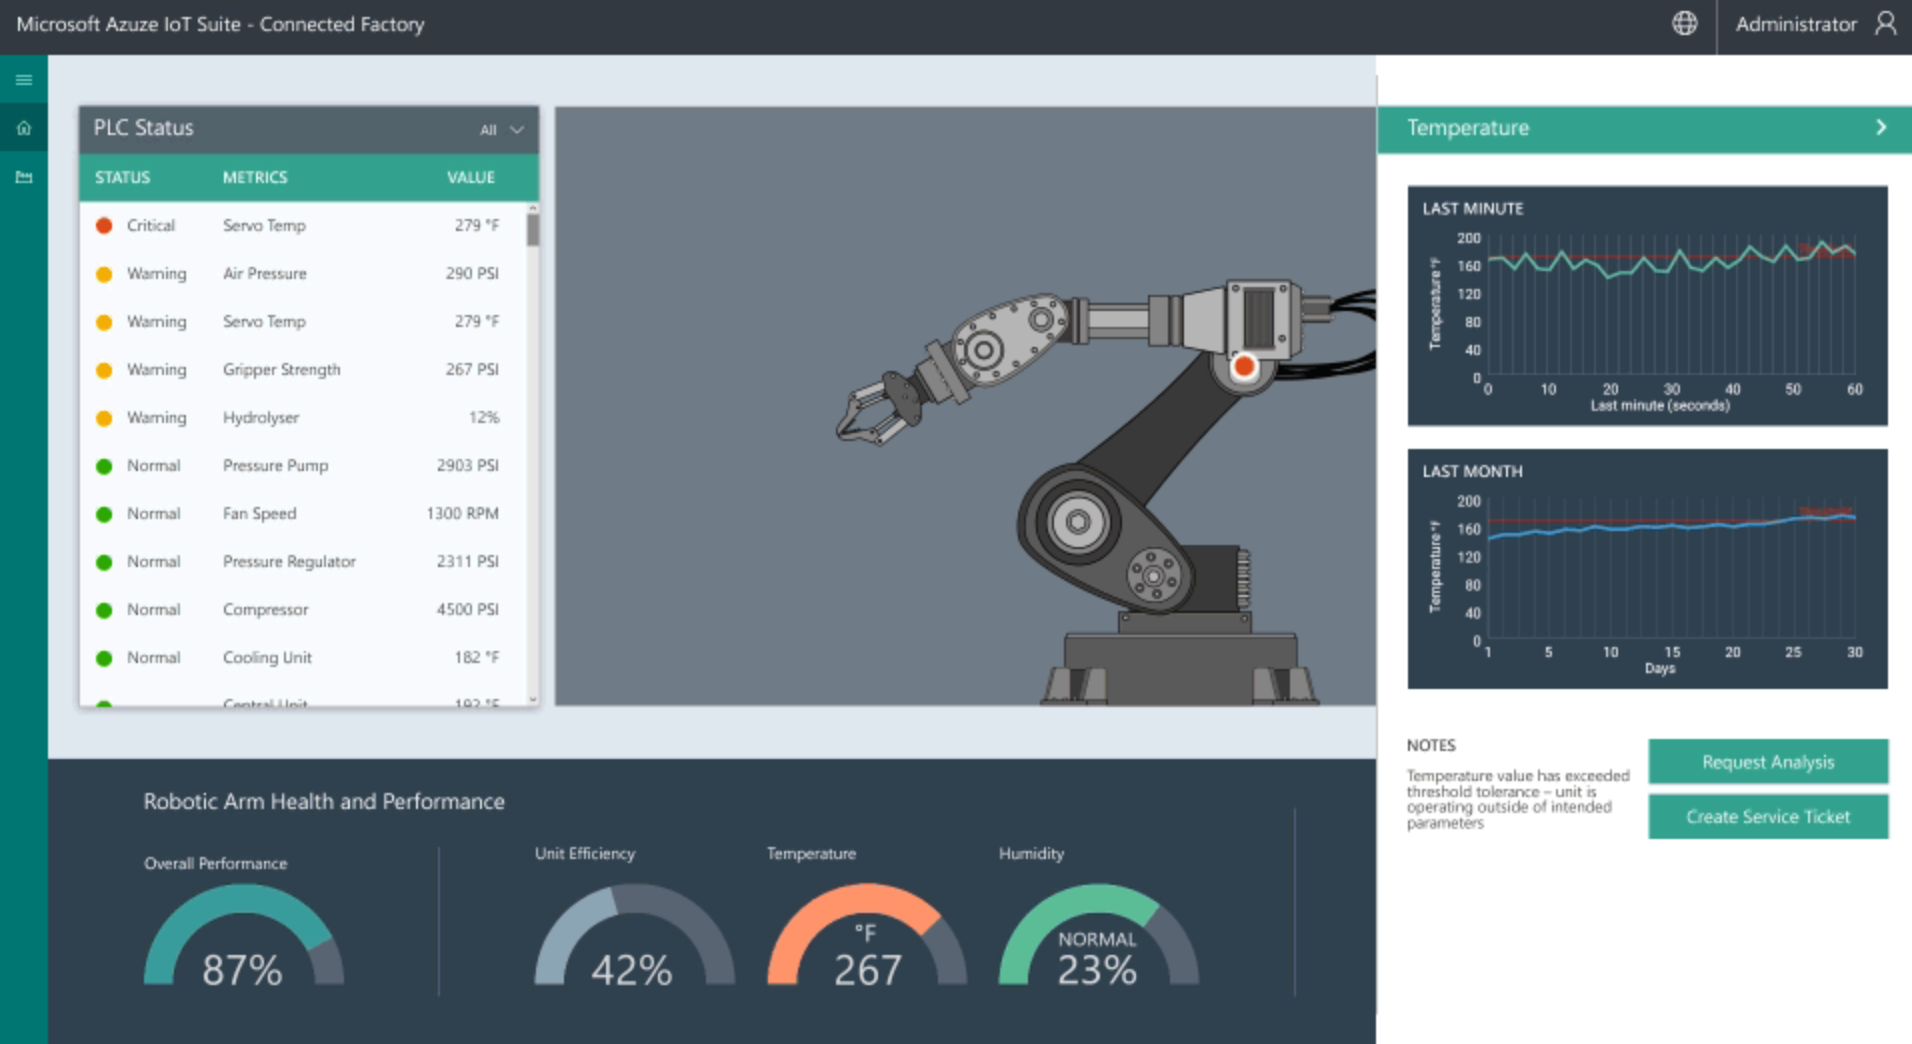

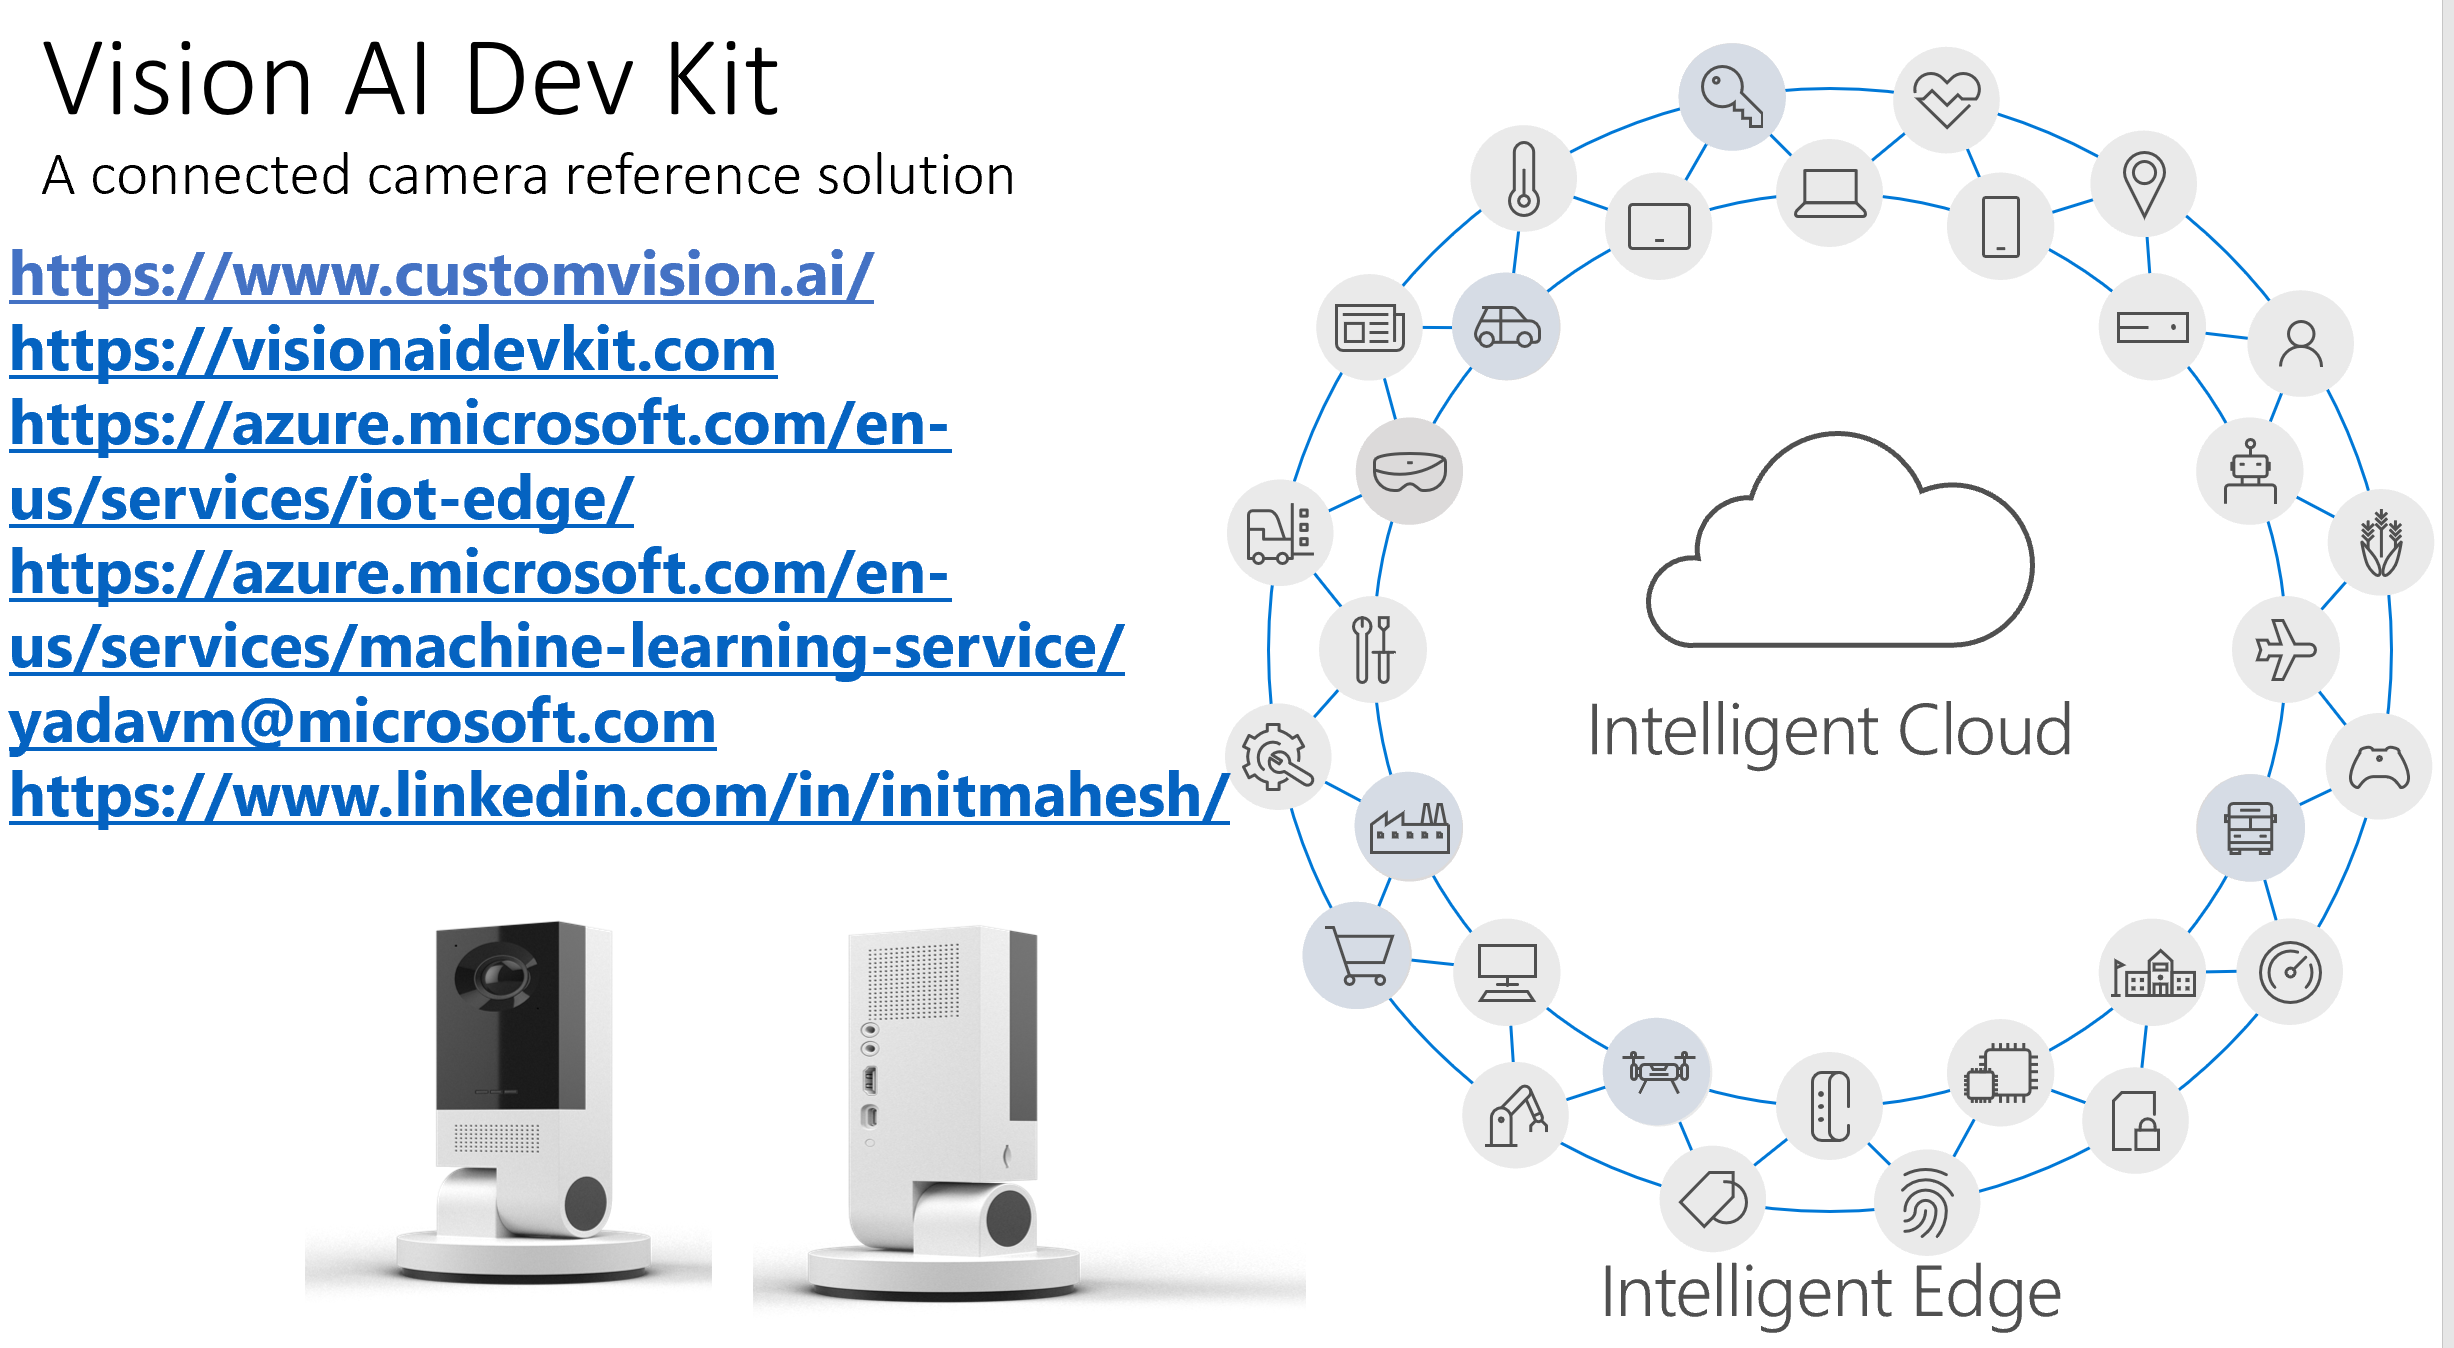